# Introduction to Differential Equations

---

# Exercises

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy.linalg as lin
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D

## 1. LIF model with time-varying input current

In our lecture example of the LIF model, we used a constant $I_{input}$ for simplicity and to allow for a tractable analytical solution. However, the problem becomes much more interesting when $I_{input}$ also varies with time, such that:

$$
C \frac{dV}{dt} = (E_\text{leak} - V) \frac{1}{R} + I(t)
$$

Assuming $RC = 20 ms$, $E_{leak} = -70 mV$, and $V_0 = -70 mV$, use Euler's method with stepsize $1 ms$ to model the above differential equation from $t = 0$ to $t = 1 s$ with the following input currents:

1. $I(t)$ is a step-function, where $I(t) = 1000C$ amps for $250$ ms $< t < 750$ ms and $I(t) = 0$ everywhere else.
2. $I(t) = I_0\sin(\omega t)$, where $I_0 = 1000C$ amps and angular frequency $\omega = 10$

**Note:** Don't think too hard about the $C$ in the input current functions -- this is just to "cancel out" the $C$ in the differential equation when it gets moved to the right side (i.e. just use ``1000`` and not ``1000*C`` in your code).

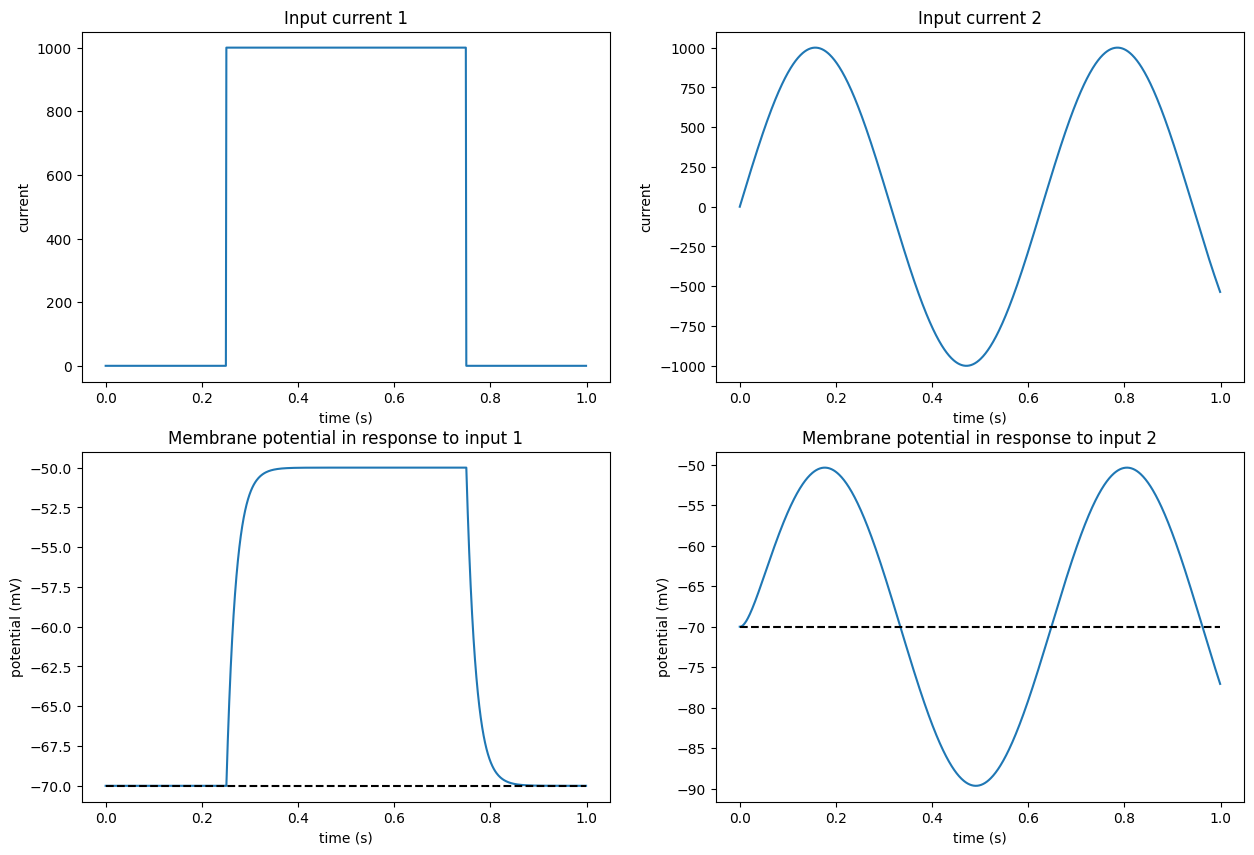

In [3]:
# initialize constants
RC = 0.02
E_leak = -70
V_init = -70

# 1. make a function for the input current
# step function
def I_in1(t):
    if (t>0.25) & (t<0.75):  
        return 1000       
    else:
        return 0
    
# sinusoid      
def I_in2(t):
    return 1000*np.sin(10*t)
            

# 2. function for membrane potential dynamics
# I'm using 'i' to indicate which input current to use
def dV_dt(V,t,i):
    if i==1:
        return (E_leak-V)/RC + I_in1(t)
    elif i==2:
        return (E_leak-V)/RC + I_in2(t)
    else:
        return 0


# 3. apply Euler's method   
h = 0.001   # stepsize
t = np.arange(0,1,h)
V_em1 = np.zeros_like(t) # for the step function
V_em2 = np.zeros_like(t) # for the sinusoid
N = np.size(t)
V_em1[0] = V_init
V_em2[0] = V_init
for n in np.arange(1,N):
    V_em1[n] = h*dV_dt(V_em1[n-1],t[n-1],1) + V_em1[n-1]
    V_em2[n] = h*dV_dt(V_em2[n-1],t[n-1],2) + V_em2[n-1]
    
    
# 4. plot results
# include a plot for both the membrane potential and the input current
_, axs = plt.subplots(2,2,figsize=(15,10))

# input current 1
I1_plot = [I_in1(i) for i in t]
axs[0,0].plot(t,I1_plot)
axs[0,0].set_title("Input current 1");
axs[0,0].set_xlabel("time (s)")
axs[0,0].set_ylabel("current");

# membrane potential to input 1
axs[1,0].plot(t,V_em1)
axs[1,0].plot(t,E_leak*np.ones_like(t),'k--')
axs[1,0].set_title("Membrane potential in response to input 1");
axs[1,0].set_xlabel("time (s)")
axs[1,0].set_ylabel("potential (mV)");

# input current 2
axs[0,1].plot(t,I_in2(t))
axs[0,1].set_title("Input current 2");
axs[0,1].set_xlabel("time (s)")
axs[0,1].set_ylabel("current");

# membrane potential to input 2
axs[1,1].plot(t,V_em2)
axs[1,1].plot(t,E_leak*np.ones_like(t),'k--')
axs[1,1].set_title("Membrane potential in response to input 2");
axs[1,1].set_xlabel("time (s)")
axs[1,1].set_ylabel("potential (mV)");

Next, plot slope fields for $\frac{dV}{dt}$ separately for each input current using the intervals $t = [0,1] s$ and $V = [-100, -30] mV$. Use 20 samples in each dimension.

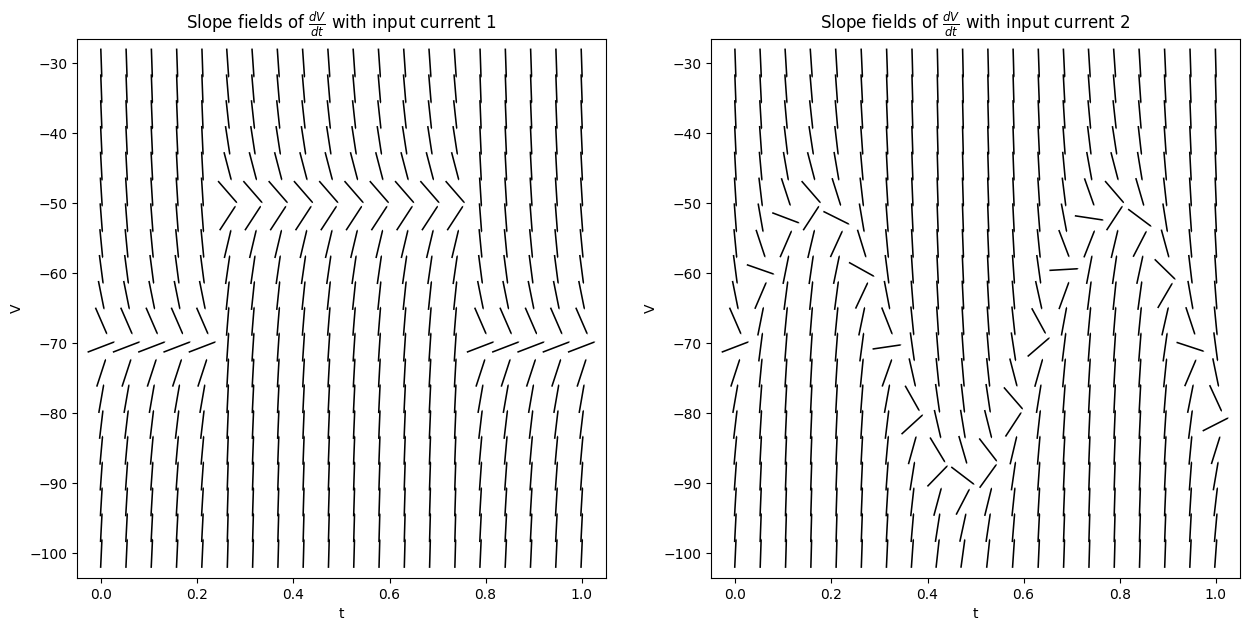

In [4]:
_, axs = plt.subplots(1,2,figsize=(15,7))

# 1. define sample points to compute the slopes
t = np.linspace(0,1,20)
V = np.linspace(-100,-30,20)

# 2. iterate over points to plot the slopes and create the slope field
for j in t:
    for k in V:
        slope1 = dV_dt(k,j,1)
        slope2 = dV_dt(k,j,2)
        axs[0].quiver(j,k,1,slope1,angles='xy',width=0.003,headwidth=1,headlength=1,pivot='mid')
        axs[1].quiver(j,k,1,slope2,angles='xy',width=0.003,headwidth=1,headlength=1,pivot='mid')
        
axs[0].set_title(r"Slope fields of $\frac{dV}{dt}$ with input current 1");
axs[0].set_xlabel("t")
axs[0].set_ylabel("V");
axs[1].set_title(r"Slope fields of $\frac{dV}{dt}$ with input current 2");
axs[1].set_xlabel("t")
axs[1].set_ylabel("V");


---
## 2. Drift-diffusion model
Alongside studying neural circuitry, differential equations have also been used to study cognitive processes such as decision making. Specifically, tasks studying *evidence accumulation* use differential equations to model behavior, an example of which is known as the *Poisson clicks task*. In this task, rats are presented with differing numbers of auditory clicks from left and right speakers in a behavioral chamber. Following the click train presentation, the animal must choose the side with the greater number of clicks. Below is a figure representation of the task (Brunton, Botvinick, & Brody, *Science*, 2013).

<img src="pclicks.png" width=600>

The process that describes the animal's ability to infer the side with greater clicks (the process of evidence accumulation) can be modeled by a *stochastic differential equation*, also known as the *drift-diffusion model*. This model describes how an internal decision variable evolves over time in the presence of auditory impulses and various sources of noise. An influential version of the drift-diffusion model was introduced by Brunton, Botvinick, and Brody (2013), explicitly:

$$
\frac{da}{dt} = (\delta_{t,t_R} \cdot \eta_r \cdot C - \delta_{t,t_L} \cdot \eta_L \cdot C) + \lambda a
 + \sigma_a \frac{dW}{dt} $$

Solving the above eqation will give us the accumulator memory, $a$, which represents the estimate of the right versus left evidence accrued at some point in time. 

The first term, $(\delta_{t,t_R} \cdot \eta_r \cdot C - \delta_{t,t_L} \cdot \eta_L \cdot C)$, describes how left or right clicks change the accumulator memory, where
- $C$ is the click magnitude
- $\delta_{t,t_R}$ and $\delta_{t,t_L}$ are delta functions at the times of the right and left clicks
- $\eta_R$ and $\eta_L$ describe sensory noise that scales the magnitude of accumulated right or left clicks, which are independently drawn from $N(0,\sigma_s)$

A second differential equation describes sensory adaptation of subsequent clicks, impacting the click magnitude $C$ over time by:

$$
\frac{dC}{dt} = \frac{1-C}{\tau_{\phi}} + (\phi - 1)C(\delta_{t,t_R}+\delta_{t,t_L})
$$

$\phi$ parameterizes how $C$ is scaled after each click, where $\phi>1$ represents facilitation (i.e. the magnitude of $C$ grows with each click) and $\phi<1$ represents depression (i.e. the magnitude of $C$ shrinks with each click). $\tau_{\phi}$ is the time constant that dictates how quickly $C$ recoveres to it's unadapted value of $1$.

The second term, $\lambda a$, describes the consistent drift in the accumulator memory, where $\lambda$ parameterizes the rate (with time constant $\tau=\frac{1}{\lambda}$) and direction of the drift. When $\lambda < 0$, the accumulator memory is "forgetful" and drifts toward $a = 0$, meaning later clicks affect the decision more than earlier clicks. When $\lambda > 0$, the accumulator memory is "unstable" and drifts away from $a = 0$, where earlier clicks affect the decision more than later clicks.

The last term, $\sigma_a \frac{dW}{dt}$, describes the "diffusion" element of the model, which is the noise attributed to the accumulator estimate $a$. $\frac{dW}{dt}$ is a white-noise Wiener process, also referred to as brownian motion, scaled by $\sigma_a$.

A visual example of a solution is illustrated in box 1 of this study.

<img src="ddm.png" width=600>

The black trace represents the accumulator estimate $a$ over time, where the influence of parameters introduced above are pointed out on the plot. The value at the end of the trial represents the accumulator's belief in which side had more clicks, and its magnitude is proportional to its "confidence" in the choice. Additional model parameters include:
- $B$, the decision boundary, which describes the threshold of evidence needed to make a decision
- $bias$, which shifts the "neutral" evidence state toward the left or right decision boundary, representing an inherent bias towards one of the two sides

While $B$ and $bias$ are generally included in drift diffusion models, as well as a "lapse rate" parameter that parameterizes the fraction of trials on which the animal responds randomly, we'll be ignoring these for the purpose of this exercise.

### 2.1: Generating click trains

In this exercise, we'll be numerically solving for the accumulator variable $a$ using the above differential equation for randomly generated trains of right and left clicks. But before we can do that, we need to construct the input stimulus. Using details from Brunton's and colleagues' supplementary material, we'll construct a function that generates randomly distributed click stimuli for both "left" and "right" clicks. Specifically, this function should output two delta functions at the click times for right and left clicks, or $\delta_{t,t_R}$ and $\delta_{t,t_L}$ above. Delta functions are a can of worms that we won't go into for this exercise, so we'll simplify things by assuming these functions take the form:

$$\delta_R(t) = \left\{ 
  \begin{array}{ c l }
    \frac{1}{dt} & \quad \textrm{if } t = t_R \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right.$$

for right clicks, where $dt$ is the time step between stimulus samples and $t_R$ are the times of the right clicks. This will replace $\delta_{t,r_R}$ in the differential equation. Similarly for left clicks: 

$$\delta_L(t) = \left\{ 
  \begin{array}{ c l }
    \frac{1}{dt} & \quad \textrm{if } t = t_L \\
    0                 & \quad \textrm{otherwise}
  \end{array}
\right.$$

where $t_L$ are the times of the left clicks, replacing $\delta_{t,t_L}$.

Create this function with the following properties:
1. Use an input variable, ``stim_dur``, to indicate how long you want each stimulus or click train to last in seconds
2. Use a second input variable, ``dt``, to indicate the step size between stimulus samples. In other words, $1/dt$ is the sampling rate of the stimulus, meaning that the output click trains should be length ``stim_dur`` $/$ ``dt``
3. Draw the number of right clicks from $\text{Pois}(r_R)$ and the number of left clicks from $\text{Pois}(r_L)$, where $r_R$ and $r_L$ are the click rates for right and left clicks, respectively. These rates should be randomly drawn such that $r_L+r_R = 20$ clicks per second.
4. Randomly distrute the right and left clicks throughout the stimulus interval (i.e. choose random times within the interval of length ``stim_dur`` $/$ ``dt`` corresponding to each of the clicks)
5. Return two variables, ``delta_right`` and ``delta_left``, corresponding to $\delta_R$ and $\delta_L$ above


In [4]:
def delta_clicks(stim_dur=1,dt=0.01):
    # number of samples/time stamps for click train/delta function
    n_samples = np.round(stim_dur/dt).astype('int')
    
    # click rates
    exp_rate = 20
    rate_r = np.random.choice(exp_rate)      # randomly choose right rate
    rate_l = exp_rate-rate_r           # get left rate via constraint
    
    # randomly distribute click times
    n_right = np.random.poisson(rate_r*stim_dur)              # get number of right clicks from poisson distribution
    r_click_locs = np.random.choice(n_samples,n_right,False)  # choose random locations for the right clicks
    n_left = np.random.poisson(rate_l*stim_dur)               # get number of left clicks from poisson distribution
    l_click_locs = np.random.choice(n_samples,n_left,False)   # choose random locations for the left clicks
    
    delta_right = np.zeros(n_samples)   # initialize right delta function
    delta_right[r_click_locs] = 1/dt    # set times of right clicks to 1/dt, based on definition above
    delta_left = np.zeros(n_samples)    # initialize left delta function
    delta_left[l_click_locs] = 1/dt     # set times of left clicks to 1/dt, based on definition above
        
    return delta_right,delta_left

### 2.2: Ideal performance

Now that we have a function to generate click trains, we can start approximating the drift-diffusion model. To get an intuition for how each term affects the accumulator, we'll start with a simplified version of the model and then introduce the pieces back in. 

To simplify the model, we can assume conditions that invoke "ideal performance". This is achieved by setting:

$$
\lambda=0, \sigma_a^2 = \sigma_s^2 = 0, \frac{dC}{dt} = 0
$$

This reduces the accumulator to one that only pays attention to the left and right clicks, unaffected by noise, drift, or adaptation:

$$
\frac{da}{dt} = (\delta_{t,t_R} \cdot C - \delta_{t,t_L} \cdot  C)
$$

where $C$ stays at a constant value of 1.

Use Euler's method to approximate $a$ with initial condition $a(0) = 0$, and parameters $\text{stim_dur}=1s$, $dt=0.001s$ and plot your solution using randomly generated click trains from your function above.

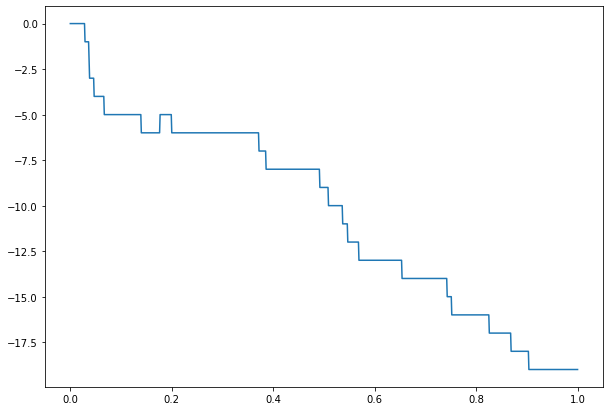

In [5]:
# initialize variables
stim_dur=1
dt = 0.001
ts = np.arange(0,stim_dur+dt,dt)

## 1. Use Euler's method to approximate a
a = np.zeros(np.size(ts))                             # initialize a
delta_right,delta_left = delta_clicks(stim_dur,dt)    # get click trains

# for-loop to approximate
for t in np.arange(1,np.size(ts)):  # start at second index
    a[t] = a[t-1] + (delta_right[t-1] - delta_left[t-1])*dt

## 2. Plot your solution
plt.figure(figsize=(10,7))
ts = np.arange(0,stim_dur+dt,dt)  # timestamps for x-axis
plt.plot(ts,a)


### 2.3: Adding in the drift

You may have noticed that the above solution looks a lot like a step function. Indeed, it perfectly counts the total number of left and right clicks at any point in time. But things in the real world aren't quite so perfect; sometimes we may start to forget or misremember the number of clicks we've accumulated. This is where the "drift" part of the drift-diffusion model comes into play.

Reintroducing the drift term gives us the equation:

$$
\frac{da}{dt} = (\delta_{t,t_R} \cdot C - \delta_{t,t_L} \cdot  C) + \lambda a
$$

Use Euler's method to approximate this new accumulator value with the drift term, using the same initial conditions and setting  $\lambda = -20$, and plot your solution. You can do this below or by editing your code above.

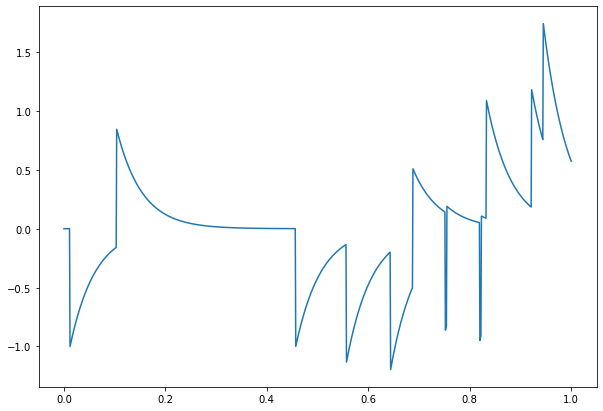

In [6]:
# initialize variables
stim_dur=1
dt = 0.001
ts = np.arange(0,stim_dur+dt,dt)
lambd = -20

# 1. Use Euler's method to approximate a
plt.figure(figsize=(10,7))
a = np.zeros(np.size(ts))

delta_right,delta_left = delta_clicks(stim_dur,dt)

for t in np.arange(1,np.size(ts)):

    a[t] = a[t-1] + (lambd*a[t-1] + (delta_right[t-1] - delta_left[t-1]))*dt

plt.plot(ts,a)

Our negative value for $\lambda$ demonstrates a forgetful or "leaky" accumulator. We no longer see perfect steps, but instead see our accumulator decay in the absense of new clicks.

### 2.4: Adding in adaptation

As you'll learn in your core courses, oftentimes repeated presentations of a stimulus will lead to sensory adaptation. This can manifest as a *depression*, where sensory receptors decrease their sensitivity to the stimuli, or as a *facilitation*, where sensory receptors increase their sensitivity to the stimuli. This phenomenon is accounted for in the drift-diffusion model by having an additional differential equation describe the dynamics of the click magnitude $C$. 

To observe how adaptation of $C$ affects our accumulator, we'll take a step back before adding the drift term and use the equation

$$
\frac{da}{dt} = (\delta_{t,t_R} \cdot C - \delta_{t,t_L} \cdot  C)
$$

except instead of $C$ being set to a constant $1$, it will also be updated according to 

$$
\frac{dC}{dt} = \frac{1-C}{\tau_{\phi}} + (\phi - 1)C(\delta_{t,t_R}+\delta_{t,t_L})
$$

This turns our drift-diffusion model into a *system* of differential equations. Much like a single differential equation, Euler's method can be used to approximate a system of differential equations. The only difference is that you're updating the value of multiple variables (in this case two) instead of one. By editing your code above or by writing new code below, approximate the accumulator with click adaptiation and plot your results. 

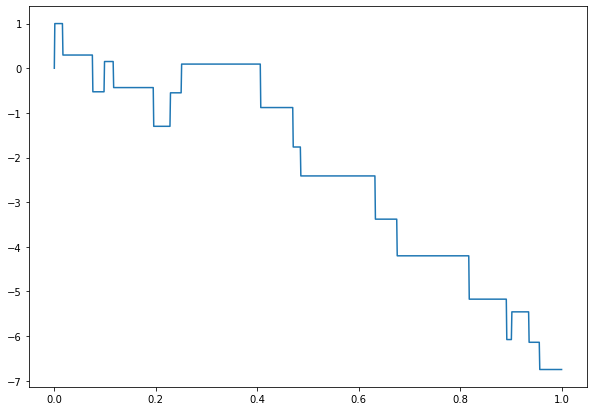

In [7]:
# initialize variables
stim_dur=1
dt = 0.001
n_iter = 1
ts = np.arange(0,stim_dur+dt,dt)

tau_phi = 0.05
phi = 0.6


# 1. Use Euler's method to approximate a
plt.figure(figsize=(10,7))
a = np.zeros(np.size(ts))


delta_right,delta_left = delta_clicks(stim_dur,dt)
C = np.ones(np.size(ts))

for t in np.arange(1,np.size(ts)):
    a[t] = a[t-1] + (delta_right[t-1] - delta_left[t-1])*C[t-1]*dt
    C[t] = C[t-1] + ((1-C[t-1])/tau_phi + (phi-1)*C[t-1]*(delta_right[t-1]+delta_left[t-1]))*dt

plt.plot(ts,a)

You may have noticed that the steps now vary in size; specifically, they're getting smaller with repeated clicks, which is consistent with depression when $\phi < 1$.

### 2.5: Adding in noise

Being forgetful isn't the only imperfection we need to account for. Similar to how you may *think* you feel your phone buzzing in your pocket when it actually didn't, the accumulator may *think* it heard a click when it actually didn't (or, conversely, miss a click that was actually played). Additionally, while we try our best for sound isolation, you can't completely eliminate irrelevant auditory stimuli, which can also interfere with your perception of the clicks you hear. Both of these are captured by adding noise to the model.

There are two sources of noice included in the drift-diffusion model. The first is the term $\sigma_a \frac{dW}{dt}$, which constitutes the "diffusion" part of the drift-diffusion model. $\frac{dW}{dt}$ denotes a white noise Weiner process, also known as Brownian motion or a "random walk". This noise can be thought of as general uncertainty in the accumulator value, akin to accidentally missing clicks or hearing clicks that didn't occur. The second is captured by the variables $\eta_r$ and $\eta_l$, which represents sensory noise that may interfere with the magnitude of right and left clicks.

These sources of noise are the last additions to the drift-diffusion model we'll visit in this exercise. To see the effect of noise on the "ideal" model, approximate the drift-diffusion model with only the sources of noise such that

$$
\frac{da}{dt} = (\delta_{t,t_R} \cdot \eta_r \cdot C - \delta_{t,t_L} \cdot \eta_L \cdot C) + \sigma_a \frac{dW}{dt} 
$$

holding $C=1$. Use the values $\sigma_a = 2$ and $\sigma_s = 0.1$.

**TIPS:**
- Without worring too much about the specifics of a Weiner process, you can use the following principle to compute it in Euler's method: $dW \sim \sqrt{dt} N(0,1)$
- Remember that $\eta_r$ and $\eta_l$ are independently drawn from $N(0,\sigma_s)$

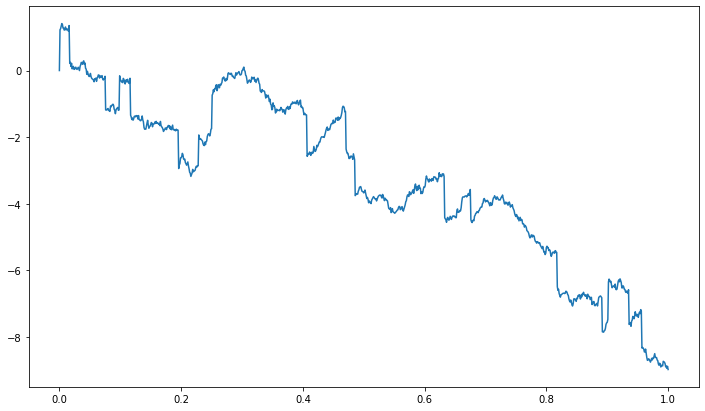

In [8]:
# initialize variables
stim_dur=1
dt = 0.001
ts = np.arange(0,stim_dur+dt,dt)

sig_a = 2
sig_s = 0.1


# 1. Use Euler's method to approximate a
plt.figure(figsize=(12,7))
a = np.zeros(np.size(ts))


#delta_right,delta_left = delta_clicks(stim_dur,dt)
C = np.ones(np.size(ts))

for t in np.arange(1,np.size(ts)):

    eta_r = np.random.normal(1,sig_s)
    eta_l = np.random.normal(1,sig_s)
    dW = np.random.normal(0,1)

    a[t] = a[t-1] + (eta_r*delta_right[t-1] - eta_l*delta_left[t-1])*dt + sig_a*np.sqrt(dt)*dW

plt.plot(ts,a)

### 2.6: Putting it all together

Now that we've looked at the separate impact of each factor of the drift-diffusion model, let's finally put everything together and approximate a solution to the full model.

$$
\frac{da}{dt} = (\delta_{t,t_R} \cdot \eta_r \cdot C - \delta_{t,t_L} \cdot \eta_L \cdot C) + \lambda a
 + \sigma_a \frac{dW}{dt} 
$$

$$
\frac{dC}{dt} = \frac{1-C}{\tau_{\phi}} + (\phi - 1)C(\delta_{t,t_R}+\delta_{t,t_L})
$$

Let's use the same initial conditions and parameters we've used along the way: $\text{stim_dur} = 1, dt = 0.001, a(0) = 0, C(0) = 1, \lambda = -20, \tau_{\phi} = 0.05, \phi = 0.6, \sigma_a = 2, \sigma_s = 0.1$.

As a bonus, you can plot the solution to the full model along with solutions to the various iterations we've looked at above to see how they all differ!

Text(0.5, 1.0, 'Drift-Diffusion Model')

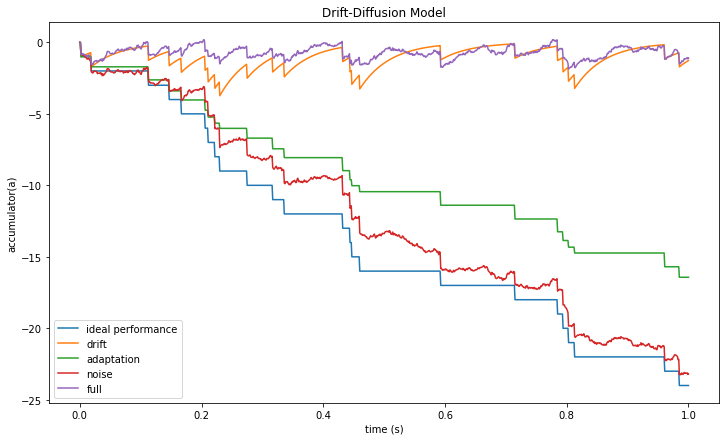

In [9]:
# initialize variables
stim_dur=1
dt = 0.001
ts = np.arange(0,stim_dur+dt,dt)

# set model parameters
lambd = -20
tau_phi = 0.05
phi = 0.6
sig_a = 2
sig_s = 0.1

## 1. Use Euler's method to approximate a
# initialize a
a_1 = np.zeros(np.size(ts))
a_2 = np.zeros(np.size(ts))
a_3 = np.zeros(np.size(ts))
a_4 = np.zeros(np.size(ts))
a_5 = np.zeros(np.size(ts))

# get the right and left clicks
delta_right,delta_left = delta_clicks(stim_dur,dt)
C = np.ones(np.size(ts))   # initialize C
    
# for loop for euler's method    
for t in np.arange(1,np.size(ts)):

    # pre-draw values to use in accumulator
    eta_r = np.random.normal(1,sig_s)
    eta_l = np.random.normal(1,sig_s)
    dW = np.random.normal(0,1)

    # ideal performance
    a_1[t] = a_1[t-1] + (delta_right[t-1] - delta_left[t-1])*dt 
    
    # drift only
    a_2[t] = (1 + lambd*dt)*a_2[t-1] + (delta_right[t-1] - delta_left[t-1])*dt
    
    # C adaptation only
    a_3[t] = a_3[t-1] + (delta_right[t-1] - delta_left[t-1])*C[t-1]*dt 
    
    # noise only
    a_4[t] = a_4[t-1] + (eta_r*delta_right[t-1] - eta_l*delta_left[t-1])*dt + sig_a*np.sqrt(dt)*dW
    
    # all together
    a_5[t] = (1 + lambd*dt)*a_5[t-1] + (eta_r*delta_right[t-1] - eta_l*delta_left[t-1])*C[t-1]*dt + sig_a*np.sqrt(dt)*dW
    
    # update C
    C[t] = C[t-1] + ((1-C[t-1])/tau_phi + (phi-1)*C[t-1]*(delta_right[t-1]+delta_left[t-1]))*dt

## 2. Plot results
plt.figure(figsize=(12,7))
plt.plot(ts,a_1)
plt.plot(ts,a_2)
plt.plot(ts,a_3)
plt.plot(ts,a_4)
plt.plot(ts,a_5)
plt.legend(('ideal performance','drift','adaptation','noise','full'))
plt.xlabel('time (s)')
plt.ylabel('accumulator(a)')
plt.title('Drift-Diffusion Model')